# 变分自编码VAE

## 导入有关函数

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

In [2]:
# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
# 超参数设置
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 20
batch_size = 64
learning_rate = 1e-3

## 数据集

In [5]:
dataset = torchvision.datasets.MNIST(root=os.path.join('data','MNIST'),
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)  

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                         drop_last=True)

In [6]:
img,label = next(iter(data_loader))
img.shape,label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## 创建VAE模型

In [7]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # log(方差) 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # 整个前向传播过程：编码 -> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

## 训练

In [8]:
# 实例化一个模型
model = VAE().to(device)

In [9]:
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
losses = []
outs,x_concats = [],[]
for epoch in range(num_epochs):
    print(epoch,end=' ')
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        
        # 计算对数似然函数和KL散度
        reconst_loss = 0.5*(x_reconst-x).pow(2).sum()         # 正态损失
#         reconst_loss = -torch.sum(x*(x_reconst).log()+(1-x)*(1-x_reconst).log()) 
#       reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False) 
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div
        
        
        # 反向传播和优化
        optimizer.zero_grad()  # 参数梯度设置为0
        loss.backward()        # 计算参数的梯度
        optimizer.step()       # 更新参数
          
        
        if (i+1) % 100 == 0: losses.append([reconst_loss.item(), kl_div.item()])

    print(loss.item())
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(20, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out,
                   os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)),
                   nrow = 4)

        # 重构的图像
        x_part = x[:20]
        out, _, _ = model(x_part)
        x_concat = torch.cat([x_part.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(out.view(-1, 1, 28, 28),
                   os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)),
                   nrow = 4)

0 1587.4749755859375
1 1513.9849853515625
2 1489.052001953125
3 1461.6031494140625
4 1390.1080322265625
5 1401.7611083984375
6 1335.5328369140625
7 1394.95947265625
8 1370.417236328125
9 1405.21728515625
10 1338.2811279296875
11 1332.988525390625
12 1314.10302734375
13 1314.29345703125
14 1213.47119140625
15 1245.556396484375
16 1380.4305419921875
17 1383.224609375
18 1222.5343017578125
19 1276.7813720703125


## 结果分析

### 生成图像和重构图像

In [11]:
# 使用png图片制作动画
import imageio
gif_images = []
for d in range(1,21):
    file = f"samples\sampled-{d}.png"
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("vae-samples.gif", gif_images, fps=1)   # 转化为gif动画

In [12]:
# 使用png图片制作动画
import imageio
gif_images = []
for d in range(1,21):
    file = f"samples\\reconst-{d}.png"
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("vae-reconst.gif", gif_images, fps=1)   # 转化为gif动画

### 误差

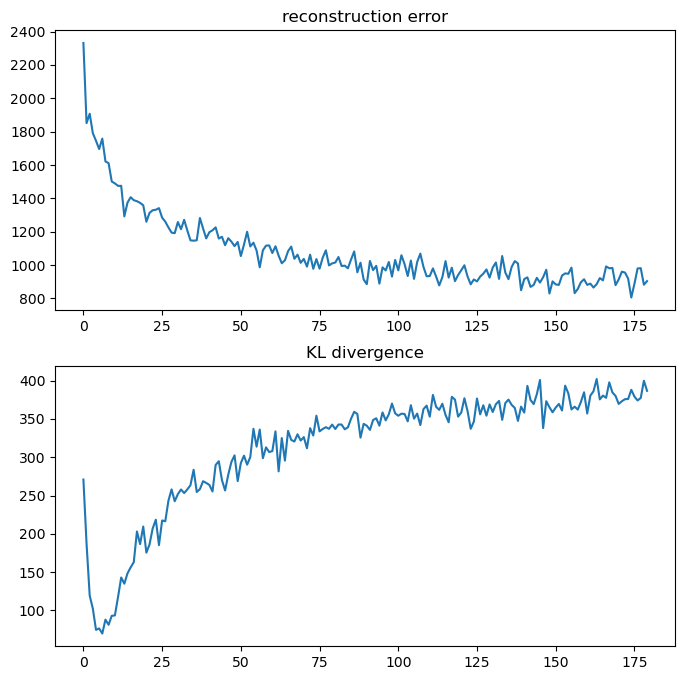

In [13]:
# 误差
fig,ax = plt.subplots(2,figsize = (8,8))
_ = ax[0].plot(np.array(losses)[:,0]),ax[0].set_title('reconstruction error')
_ = ax[1].plot(np.array(losses)[:,1]),ax[1].set_title('KL divergence')
_ = plt.show()

### 隐空间流行分析

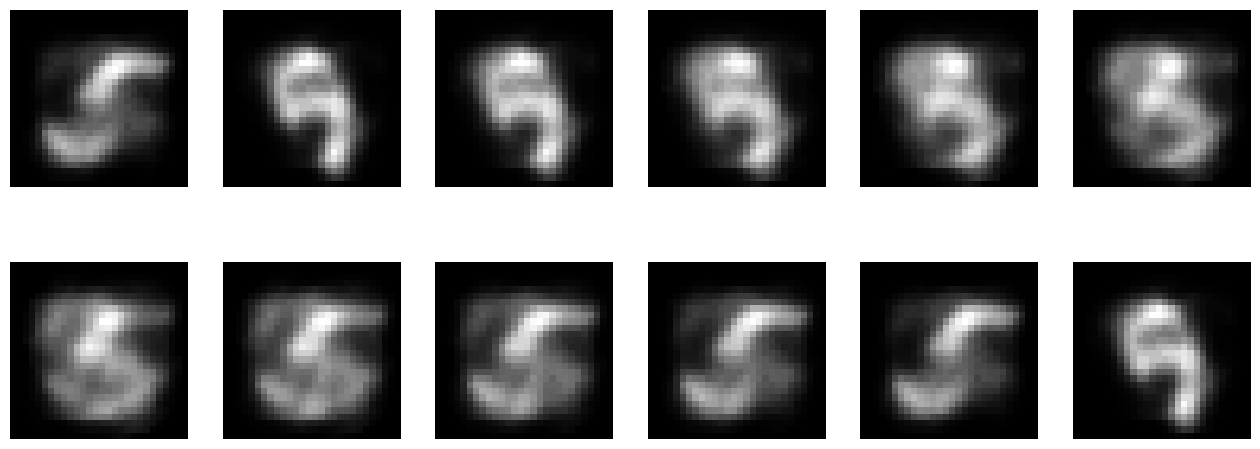

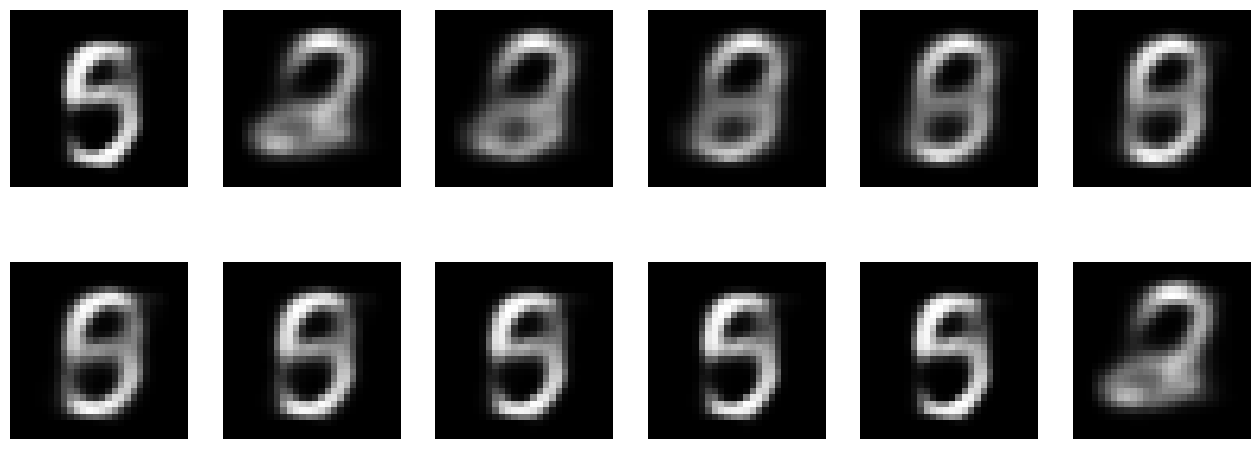

In [18]:
with torch.no_grad():
    # 在z空间插值，得到相应的图像
    z1 = torch.randn(1, z_dim).to(device)
    out1 = model.decode(z1).view(28, 28)

    z2 = torch.randn(1, z_dim).to(device)
    out2 = model.decode(z2).view(28, 28)

    outs = [out1]
    for a in np.linspace(0,1,10):
        z = z1*a+(1-a)*z2
        out =  model.decode(z).view(28, 28)
        outs.append(out)
    outs.append(out2)
    
    # 画图
    fig,ax = plt.subplots(2,len(outs)//2,figsize=(16,6))
    ax = ax.flatten()
    for i in range(len(outs)):
        _ = ax[i].imshow(outs[i].cpu(),'gray')
        _ = ax[i].axis('off')
plt.show()

# 问题

使用Cartoon Set数据集训练VAE。

需要修改的地方
- dataset  
- image_size 
- P Q 
- ...